Fixed Source MC code

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os

import placzek as pcz

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [2]:
PL = 1
LT = 1

# Base directory
base_dir = 'cross_sections_Janis'

# Load data directly with os.path.join
Cnat_total = np.loadtxt(os.path.join(base_dir, 'C', 'Cnat_total.csv'), delimiter=';', skiprows=3)
Cnat_scattering = np.loadtxt(os.path.join(base_dir, 'C', 'Cnat_scattering.csv'), delimiter=';', skiprows=3)

Fe_total = np.loadtxt(os.path.join(base_dir, 'Fe', 'Fe_total.csv'), delimiter=';', skiprows=3)
Fe_scattering = np.loadtxt(os.path.join(base_dir, 'Fe', 'Fe_scattering.csv'), delimiter=';', skiprows=3)

Onat_total = np.loadtxt(os.path.join(base_dir, 'O', 'Onat_total.csv'), delimiter=';', skiprows=3)
Onat_scattering = np.loadtxt(os.path.join(base_dir, 'O', 'Onat_scattering.csv'), delimiter=';', skiprows=3)

U238_total = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_total.csv'), delimiter=';', skiprows=3)
U238_scattering = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_scattering.csv'), delimiter=';', skiprows=3)
U238_fission = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_fission.csv'), delimiter=';', skiprows=3)

U235_total = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_total.csv'), delimiter=';', skiprows=3)
U235_scattering = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_scattering.csv'), delimiter=';', skiprows=3)
U235_fission = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_fission.csv'), delimiter=';', skiprows=3)

Create isotopes

test 0D

In [3]:
carbon = mat_m.isotope(6,12,1.1E23,Cnat_total[:,0],Cnat_total[:,1],Cnat_total[:,1])
source = phy_m.source(GV.LL,100,GV.SOURCE_POSITION,1.,'fixed')

test 1D

In [ ]:
#carbon = mat_m.isotope(6,12,1.1E23,Cnat_total[:,0],Cnat_total[:,1],Cnat_scattering[:,1])
#iron = mat_m.isotope(26,56,8.6E22,Fe_total[:,0],Fe_total[:,1],Fe_scattering[:,1])
#uranium238 = mat_m.isotope(92,238,1.76E22,U238_total[:,0],U238_total[:,1],U238_scattering[:,1],U238_fission[:,1],2.5)
#uranium235 = mat_m.isotope(92,235,4.4E21,U235_total[:,0],U235_total[:,1],U235_scattering[:,1],U235_fission[:,1],2.5)
#source = phy_m.source(GV.LL,100,GV.SOURCE_POSITION,1.,'watt')

Create materials

In [4]:
core_list = [carbon]
core = mat_m.material(core_list)
#reflector_list = [iron,carbon]
reflector_list = [carbon]
reflector = mat_m.material(reflector_list)

Tally creation

In [5]:
#distribution = [(core,GV.L0,5),(reflector,5,GV.LEnd)]
distribution = [(core,0,GV.LEnd)]
domain = geo_m.domain(distribution,GV.LL,10000,GV.EE,10000,True)
tally = stat_m.tally(GV.LL,200)

Monte Carlo Code

In [6]:
while tally.iter <= GV.Nstories:
    # scelgo la particella da simulare
    nn = phy_c.choose_new_particle(source,1.)
    while nn.eof > 0:
        nn.position = phy_c.sample_free_flight(nn,domain)
        if geo_c.is_outofbound(nn,'space'):
            nn.eof = 0
        else:
            stat_c.count_interaction(tally,nn,domain)
            # aggiorno i dati della particella dopo l'interazione
            nn.energy = phy_c.sample_energy_stepf(nn,domain)
            nn.direction = geo_m.direction.get_rnd_direction()
            nn.weight = phy_c.new_weight(nn,domain)
            # controllo l'energia
            if geo_c.is_outofbound(nn,'energy'):
                nn.eof = 0
            else:
                # russian roulette e splitting
                stat_c.russian_roulette(nn)
                stat_c.splitting(nn)
    stat_c.wellford(tally)
stat_c.normalization(tally)

Results processing

In [7]:
avg = tally.avg
sigma = tally.sigma

plots 0D

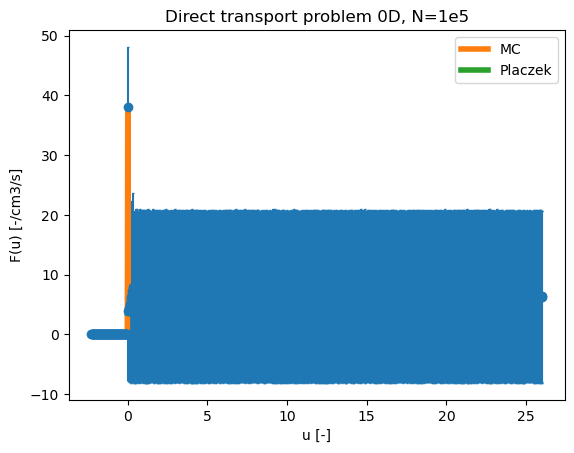

In [8]:

avg = avg.ravel()
sigma = sigma.ravel()

if LT > 0:
    xx = -np.log(tally.energyref/GV.EREF)
    yy = avg*tally.energyref
    sigma *= tally.energyref
    if PL > 0:
        plc = pcz.Lplaczek(12)
else:
    xx = tally.energyref
    yy = avg
    if PL > 0:
        plc = pcz.adj_placzek(12,domain.materials[0].macro_xs_scattering)
        plc[0] *= 1/GV.EREF

plt.errorbar(xx, yy, yerr=sigma, fmt='o', capsize=1)
plt.plot(xx,yy, linewidth='4' ,label='MC')
if PL > 0:
    plt.plot(plc[0],plc[1],linewidth='4' ,label='Placzek')
if LT > 0:
    plt.xlabel('u [-]')
    plt.ylabel('F(u) [-/cm3/s]')
else:
    plt.ylabel('F*(E) [-/cm3/s/eV]')
plt.title('Direct transport problem 0D, N=1e5')
plt.legend()
plt.show()



In [ ]:

#xx = tally.spaceref
#yy = np.zeros(len(avg[0]))
#n_curves = len(avg)
#for ii in range(len(avg)):
#    plt.errorbar(xx,avg[ii],yerr=sigma[ii],label=f"group {n_curves-ii}")
#    yy += avg[ii]
xx = GV.Groups
yy = []
for ii in avg:
    yy.append(ii[1])
plt.plot(xx,yy)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()